语义分割

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import cv2

In [2]:
data_transforms = {
    'img': transforms.Compose([
        # transforms.Resize(512),
        # transforms.CenterCrop(520),
    ]),
    'train': transforms.Compose([
        # transforms.Resize(512),
        # transforms.CenterCrop(520),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = models.segmentation.fcn_resnet101(pretrained=True).to(device)
model = model.eval()

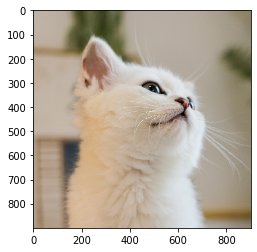

In [4]:
img = Image.open('D:\code\pytorch_learn\data\mao.jpg')
plt.imshow(img)

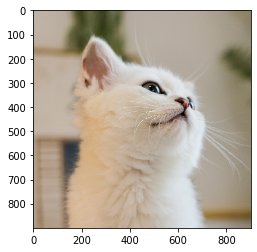

In [5]:
plt.imshow(data_transforms['img'](img))

In [6]:
inp = data_transforms['train'](img).unsqueeze(0).to(device)
print(inp.shape)

torch.Size([1, 3, 900, 900])


In [7]:
# 推断的时候不需要向后传播, 极大节省内存
with torch.no_grad():
    out = model(inp)
print(out.keys())

odict_keys(['out', 'aux'])


In [8]:
print(out['out'].shape)
print(out['aux'].shape)

torch.Size([1, 21, 900, 900])
torch.Size([1, 21, 900, 900])


In [9]:
# 降维, 从 [1, 21, 520, 520] => [21, 520, 520] => [1, 520, 520] => [520, 520]
om = torch.argmax(out['out'].squeeze(), dim=0).detach().cpu().numpy()
print(om.shape)

(900, 900)


In [10]:
print(np.unique(om))

[ 0  8 12]


In [11]:
# Define the helper function
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

[  0  64 128]


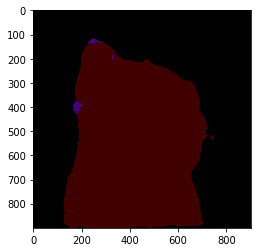

In [119]:
rgb = decode_segmap(om)
plt.imshow(rgb)

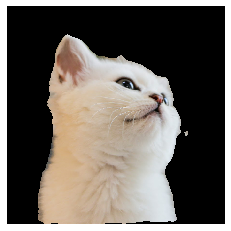

In [13]:
def image_matting(img, image_out):
    image_src = data_transforms['img'](img)

    image_out = np.where(image_out > 0, 1, 0) # 取出不是背景的像素
    image_out = np.stack((image_out, image_out, image_out), axis=2)

    out = image_src * image_out
    out = out.astype(np.uint8)
    return out

plt.imshow(image_matting(img, om)); plt.axis('off'); plt.show()

In [167]:
def segment(net, path):
  img = Image.open(path)
  print(np.array(img).shape)
  plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  inp = data_transforms['train'](img).unsqueeze(0).to(device)
  # 推断的时候不需要向后传播, 极大节省内存
  with torch.no_grad():
    out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

  # 假装作为 trimap 保存, TODO
  rgb = np.where(rgb > 0, 255, 0).astype(np.uint8)
  # alpha = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
  # alpha = alpha.reshape(list(alpha.shape) + [1])
  # rgb = np.concatenate((rgb, alpha), axis=2)
  plt.imsave('trimap.png', rgb)

  cut = image_matting(img, om)
  plt.imshow(cut); plt.axis('off'); plt.show()
  plt.imsave('cut.png', cut)

(1379, 790, 3)


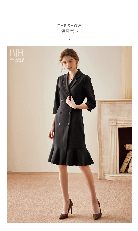

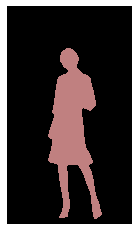

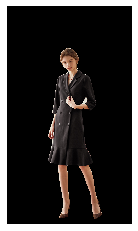

1.3426334857940674


In [168]:
import time
start = time.time()
# segment(model, 'C:/Users/tzh/Downloads/mao2.jpg')
# segment(model, r'C:\Users\tzh\Downloads\yoona.jpg')
segment(model, r'C:\Users\tzh\Downloads\dress.jpg')
# segment(model, 'C:/Users/tzh/Downloads/猫凝视.jpg')
print(time.time() - start)

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()

(440, 680, 4)
[  0 102 255]
[255]


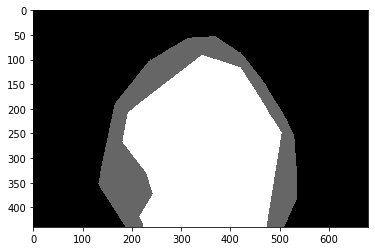

In [166]:
img = Image.open(r'D:\code\code_read\pymatting-master\data\lemur\lemur_trimap.png')
img = np.array(img)
print(img.shape)
print(np.unique(img))
print(np.unique(img[...,3]))
plt.subplot(1, 1, 1); plt.imshow(img)

In [81]:
from scipy.ndimage import morphology 
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))  # 前景
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = unknown - fg
    unknown = morphology.distance_transform_edt(unknown==0) <= np.random.randint(1, 20)
    trimap = fg * 255
    trimap[unknown] = 128
    return trimap.astype(np.uint8)

[  0 128 255]
433


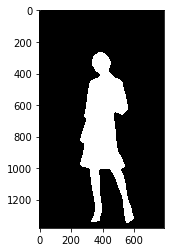

In [181]:
img = Image.open('trimap.png')
img = np.array(img)
img = generate_trimap(img)
print(np.unique(img))
print(list(img.reshape(-1)).count(128))
plt.imshow(img)

(800, 600, 4)


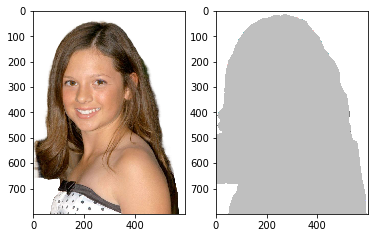

In [96]:
img = Image.open(r'D:\code\code_read\pymatting-master\data\lemur\lemur_trimap.png')
img = Image.open(r'D:\code\dataset\1803151818-00000003.png')
img = np.array(img)
print(img.shape)
plt.subplot(1, 2, 1); plt.imshow(img)
plt.subplot(1, 2, 2); plt.imshow(generate_trimap(img))

In [101]:
from pymatting import cutout

In [129]:
import cv2 as cv
THRESH = 0.8 # 二值化阈值

# 膨胀腐蚀的kernel系数
ERODE = 0.006
DILATED = 0.02


def generate_trimap_2(mask):
    # 二值化
    ret,th_mask = cv.threshold(mask,THRESH,1,cv.THRESH_BINARY)

    # 计算目标的长宽，生成对应kernel
    ax0, ax1 = np.nonzero(th_mask)
    h = ax0[-1] - ax0[0]
    w = ax1[-1] - ax1[0]
    k1 = int((h + w) * ERODE)
    k2 = int((h + w) * DILATED)
    e_kernel = np.ones((k1,k1),np.uint8)
    d_kernel = np.ones((k2,k2),np.uint8)

    # 膨胀
    dilated = cv.dilate(th_mask,d_kernel)
    dilated[dilated==1] = 0.5
    # 腐蚀
    erosion = cv.erode(th_mask,e_kernel)
    # 融合
    erosion[np.logical_and(dilated==0.5,erosion == 0)] = 0.5

    return erosion

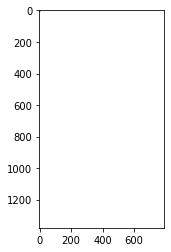

In [159]:
img = Image.open('trimap.png', )
img = np.array(img)
# img = cv2.imread('trimap.png', flags=cv2.IMREAD_GRAYSCALE)
img = generate_trimap(img)
plt.imsave('tt.png', img, cmap='gray')

img = Image.open('tt.png')
img = np.array(img)
plt.imshow(img)

cutout(
    # input image path
    # r'D:\code\dataset\1803151818-00000003.jpg',
    r'C:\Users\tzh\Downloads\dress.jpg',
    # input trimap path
    'tt.png',
    # output cutout path
    "cutout.png")

PERFORMANCE WARNING:
Thresholded incomplete Cholesky decomposition failed due to insufficient positive-definiteness of matrix A with parameters:
    discard_threshold = 1.000000e-04
    shift = 0.000000e+00
Try decreasing discard_threshold or start with a larger shift



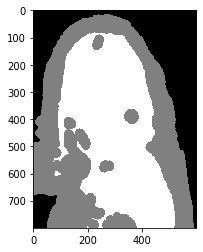

In [146]:
img = Image.open(r'D:\code\dataset\1803151818-00000003.png')
img = np.array(img)
img = img[..., 3]
img = generate_trimap(img)
plt.imsave('tt.png', img, cmap='gray')

img = Image.open('tt.png')
img = np.array(img)
plt.imshow(img)

cutout(
    # input image path
    r'D:\code\dataset\1803151818-00000003.jpg',
    # input trimap path
    'tt.png',
    # output cutout path
    "cutout.png")

In [100]:
cutout(
    r'D:\code\code_read\pymatting-master\data\lemur\lemur.png',
    r'D:\code\code_read\pymatting-master\data\lemur\lemur_trimap.png',
    'cutout.png'
)

In [118]:
new_background = np.zeros((2, 2, 3))
new_background[:, :] = [0.5, 0.5, 0.5]
print(new_background)

[[[0.5 0.5 0.5]
  [0.5 0.5 0.5]]

 [[0.5 0.5 0.5]
  [0.5 0.5 0.5]]]
